In [35]:
import pandas as pd
import json
import os
import requests as rq
import zipfile as zf
import time
import matplotlib
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt      
import math
import seaborn as sns
from collections import Counter

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score

%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

In [8]:
#csv clean up and make for the questions

#gets a directory and returns a dataframe (if the dir does not exist returns None with a print)
def load_csv(file_dir):
    df = None
    if os.path.isfile(file_dir):
        df=pd.read_csv(file_dir)
    else:
        print ("File not dir exist: " + file_dir)
    return df 

#gets a dir and a df, turns it into a csv and saves it in the dir. Returns true or false for S/F.
def save_to_csv(file_dir, dataframe, file_name):
    if dataframe is None or file_dir is None or file_name is None:
        print("dataframe/dir/name is empty, can't save to CSV")
        return False
    if os.path.exists(file_dir):
        dataframe.to_csv(file_dir+'\\'+file_name)
        return True
    else:
        print ("File dir doesn't exist: " + file_dir)
        return False 

#gets a dataframe, a threshold for dropna, a array of columns for drop, and a flag + array for fill. Returns a cleaned up dataframe.
def clean_csv(df_csv,thresh_num,clean_colums,is_fill,fill_colums):
    df=df_csv.copy()
    for item in clean_colums:
        df.drop(item,axis='columns', inplace=True)
    df = df[df['incident_id'].notna()]
    df_clean=df.dropna(axis=0,how='any',thresh=thresh_num)
    if is_fill is True:
        final=df_clean.fillna(value=fill_colums)
    else:
        final=df_clean.copy()
    return final

# gets 2 dataframes and merges them under the incident_id index
def combined_data_frame(data1,data2):
    df=data1.merge(data2).copy()
    df.dropna(axis=0,how='any')
    return df

#gets a directory of a csv, it then loads it into a dataframe, and calls clean_csv along with setting the correct index. returns the fixed dataframe, and a flag if it succeeded or not.
def adjust_dataframe(directory_string, df_threshold, df_clean_array, df_fill_flag, df_fill_array, index):
    df = load_csv(directory_string)
    if df is None:
        return df, False # i failed the dataframe
    df=clean_csv(df,df_threshold,df_clean_array,df_fill_flag,df_fill_array)
    df.set_index(index) #sets the index of the df so that we can join.
    return df, True # i succeeded in fixing the dataframe

#gets a state and a range of years, it then creates a csv that would answer our data-science questions.
def state_to_csv(state,year_min,year_max,state_path):
    path=[]
    arstee_clean=['arrestee_id',
                'arrestee_seq_num',
                'arrest_num',
                'arrest_type_id',
                'multiple_indicator',
                'offense_type_id',
                'age_id',
                'age_num',
                'sex_code',
                'race_id',
                'resident_code',
                'under_18_disposition_code',
                'clearance_ind',
                'ff_line_number',
                'age_range_low_num',
                'age_range_high_num']
    arstee_thresh_hold=1
    offender_clean=['offender_id',
                  'ethnicity_id',
                  'offender_seq_num',
                  'age_id',
                  'ff_line_number',
                  'age_range_low_num',
                  'age_range_high_num']
    offender_fill_colums={'age_num':-1,'sex_code':'U','race_id':0}
    offender_thresh_hold=3
    offender='nibrs_offender.csv'
    offense='nibrs_offense.csv'
    arstee='nibrs_arrestee.csv'
    combined_index='incident_id'
    length=year_max-year_min
    offense_clean= ['offense_id',
    'attempt_complete_flag',
    'num_premises_entered',
    'method_entry_code',
    'ff_line_number']
    offense_thresh_hold=1
    all_path = create_path(state, "all")
    for item in range(length+1):
        c_year=item+year_min
        c_path=state_path+'\\'+str(c_year)+'\\'
        path.append(c_path)
        
    y=year_min
    for p in path:
        cp=p+offense
        df_offense, flag_offense = adjust_dataframe(cp,
                                                    offense_thresh_hold,
                                                    offense_clean,
                                                    False,
                                                    None,
                                                    combined_index)
        cp=p+offender
        df_offender, flag_offender = adjust_dataframe(cp,
                                            offender_thresh_hold,
                                            offender_clean,
                                            True,
                                            offender_fill_colums,
                                            combined_index)
        if flag_offender is False or flag_offense is False:
            y+= 1
            continue
        df_offender_offense_comb =combined_data_frame(df_offender,df_offense)
        
        cp=p+arstee
        df_arstee, flag_arstee = adjust_dataframe(cp,
                                            arstee_thresh_hold,
                                            arstee_clean,
                                            False,
                                            None,
                                            combined_index)
        if flag_arstee is False:
            y+= 1
            continue
        df_year=combined_data_frame(df_offender_offense_comb,df_arstee)
        
        name=state+'_'+str(y)+'.csv'
        file=all_path+"\\"+ name
        df_year.to_csv(file)
        cols = df_year.columns.tolist()
        df_year = df_year.drop_duplicates(subset=cols)
        y+=1
               
    return path

#gets a state index and a additive for the potentioal directory, and creates it(folders and all) returns the path it generated.
def create_path(state,add_str):
    path=os.getcwd()
    folder_path ='{0}\{1}\{2}'.format(path,state,str(add_str)) #r'%s\%s\%s'%path,state,str(add_str) #/IL/2005
    try:
        os.makedirs(folder_path)
    except OSError:
        print ("Creation of the directory %s failed (Check if created)" % folder_path)
    else:
        print ("Successfully created the directory %s " % folder_path)

    return folder_path

In [5]:
#functions for set-ups and zip downloads.

#gets a url, needs to download the file, return true or false depending if the file exists or not.   
def download_zip(url, filename):
    request = rq.get(url=url, allow_redirects=True)
    if request.status_code != 200:
        print("FILE_NAME: " + filename + " NOT FOUND, REQUESTS_ERROR_CODE: " + str(request.status_code))
        return False
    else:
        open(filename,'wb').write(request.content)
        print("Successful download - " + filename)
        return True 

#gets a state index from the total dictionary and then would download all the files for that state again.
#would delete the key from the dictionary if download zip failed  
def download_state_files(state_code):
    loc_dict = states_full_dict[state_code]
    for key,item in loc_dict.items():
        if download_zip(item,key) is False:
            del states_full_dict[state_code].keys()[key]#need to be tested 
        time.sleep(1)
        
#build a dictionary from given state with file names and urls to download file 
def add_state_to_dict(base, year_bot, year_top, state_code):
    state_url_dict = dict()
    for x in range(year_bot,year_top+1):
        year = str(x)
        filename = state_code+"-"+year+'.zip'
        state_url_dict[filename] = base+year+'/'+filename #add to dict
    states_full_dict[state_code] = state_url_dict
    
#returns if a file has been found returns a string of the path it is in.    
def find(name, path):
    for root, dirs, files in os.walk(path):
        if name in files:
            return os.path.join(root, name)
        
#gets a state creates sub directories for the state and extract zip file per the given folders     
def extract_state_zip(list_of_csv,state):
    path=os.getcwd()
    
    for file in states_full_dict[state].keys():
        strip=state+'-'+'.zip'
        year=file.strip(strip)
        folder_path=create_path(state,year)
        for item in list_of_csv:
            p=find(file,path)
            if p is not None:
                zip_ref=zf.ZipFile(p, 'r').extract(member=item,path=folder_path)
            else:
                print('failed finding zip: '+item + ' || at path: ' + path)#bug its not exstracting anymore
                

    

In [6]:
#set-up of the general states array and links
states = ['IL']#,'LA','TX','WA']
states_full_dict = dict()
base_2005_2015 = "https://s3-us-gov-west-1.amazonaws.com/cg-d3f0433b-a53e-4934-8b94-c678aa2cbaf3/"
base_2016_above = " https://s3-us-gov-west-1.amazonaws.com/cg-d4b776d0-d898-4153-90c8-8336f86bdfec/"

for state in states:
    add_state_to_dict(base_2005_2015, 2005, 2015, state)
print("finished set-up")

finished set-up


In [9]:
#extracting data from downloaded files.   
path = os.getcwd()
list_of_csv=['nibrs_arrestee.csv',
             'nibrs_offender.csv',
             'nibrs_offense.csv']
for state in states:
    extract_state_zip(list_of_csv,state)
print("finished calls")

Creation of the directory C:\Users\USER\Desktop\DataScience\IL\2005 failed (Check if created)
failed finding zip: nibrs_arrestee.csv || at path: C:\Users\USER\Desktop\DataScience
failed finding zip: nibrs_offender.csv || at path: C:\Users\USER\Desktop\DataScience
failed finding zip: nibrs_offense.csv || at path: C:\Users\USER\Desktop\DataScience
Creation of the directory C:\Users\USER\Desktop\DataScience\IL\2006 failed (Check if created)
Creation of the directory C:\Users\USER\Desktop\DataScience\IL\2007 failed (Check if created)
Creation of the directory C:\Users\USER\Desktop\DataScience\IL\2008 failed (Check if created)
Creation of the directory C:\Users\USER\Desktop\DataScience\IL\2009 failed (Check if created)
Creation of the directory C:\Users\USER\Desktop\DataScience\IL\2010 failed (Check if created)
Creation of the directory C:\Users\USER\Desktop\DataScience\IL\2011 failed (Check if created)
Creation of the directory C:\Users\USER\Desktop\DataScience\IL\2012 failed (Check if cre

In [10]:
#states years to combined csv
for state in states:
    folder_path =os.getcwd()+'\\'+state #create_(state,'all')
    state_to_csv(state,2005,2015,folder_path)
    print("finished creating the ./all_csv of " + state)
print("finished the state_to_csv loop")

Creation of the directory C:\Users\USER\Desktop\DataScience\IL\all failed (Check if created)
File not dir exist: C:\Users\USER\Desktop\DataScience\IL\2005\nibrs_offense.csv
File not dir exist: C:\Users\USER\Desktop\DataScience\IL\2005\nibrs_offender.csv
finished creating the ./all_csv of IL
finished the state_to_csv loop


In [38]:
#set up for the translated columns, turning codes into a new array of words
lexicon_save_columns = {'nibrs_ethnicity.csv': ['ethnicity_id', 'ethnicity_name'], 
               'nibrs_location_type.csv': ['location_id', 'location_name','location_region_type'],
               'ref_race.csv': ['race_id', 'race_desc'],
               'nibrs_offense_type.csv': ['offense_type_id', 'offense_name', 'offense_category_name']}
lexicon_drop_columns = {'nibrs_ethnicity.csv': ['ethnicity_code','hc_flag'], 
               'nibrs_location_type.csv': ['location_code'],
               'ref_race.csv': ['race_code','sort_order','start_year','end_year','notes'],
               'nibrs_offense_type.csv': ['offense_code','crime_against','ct_flag','hc_flag','hc_code']}
id_list=['ethnicity_id','location_id','race_id', 'offense_type_id']
lexicon_path = os.getcwd()+'\\Lexicon\\'
lexicon_list = []

for k in lexicon_save_columns.keys():
    index=lexicon_save_columns[k][0]#loaction_id
    save_df=load_csv(lexicon_path+k)
    save_df.drop(lexicon_drop_columns[k], axis = 1, inplace = True)
    save_df.set_index(index, inplace=True, drop=True)
    dict_save = save_df.to_dict()
    lexicon_list.append(dict_save)
print("set-up done")

set-up done


In [39]:
# combinging the correct lexicons for later use
for state in states:
    state_all_path = os.getcwd()+'\\'+state+'\\all'
    dirs = os.listdir(state_all_path)
    print(state)
    for file in dirs:
        d = state_all_path+'\\'+file
        df = load_csv(d)
        if df is None: # debug handle
            continue
        i = 0
        for lex_dict in lexicon_list: #like on nibrs_location.csv dictionary
            col = df[id_list[i]] #id list holds the names like location_id or ethnicity_id
            for k,v in lex_dict.items():
                df[k] = col #dup cols X amount of times
                df[k].replace(lex_dict[k], inplace = True)
            i+=1
        save_to_csv(state_all_path, df, file)

print("done added columns.")

IL
done added columns.


In [13]:
#function that handles the 1st question per the state it is given. Will return a series of graphs per the question.
def plot_age_qu1_per_state(state,x_len,y_len):
    take = ['age_num', 'incident_id']
    c1 = 'age_num'
    c2 = 'incident_id'
    colors = ['c', 'm', 'y']
    labels = ['Under 18 (included)', 'Above 18', 'Unknown']
    total_bahor = None #holds all the data of the 10 years so that we can do a sum at the end   
    x, y=0,0
    row_amount,col_amount = x_len,y_len
    fig, axis = plt.subplots(nrows = row_amount, ncols = col_amount, figsize=(50,50)) #per the size of how many graphs u want
    state_all_path = os.getcwd()+'\\'+state+'\\all'
    dirs = os.listdir(state_all_path)
    for file in dirs: # run through all the files you can in the ALL folder
        d = state_all_path+'\\'+file
        df = load_csv(d)
        print(file)
        if df is None: # check if not NULL AKA exists(?)
            continue
        strip=state+'_'+'.csv'
        year=file.strip(strip)#get the year name
        
        #df.loc[df['A'] > 2, 'B'] = new_val
        df_d=age_bin(df,take,c1,c2)
        bahor = df_d[c2].value_counts() #sum them in a COUNTER form
        if total_bahor is None: #if this is the first run then get the bahor here
            total_bahor = bahor
        else:
            total_bahor += bahor #keep summing the results 
        axis[x,y].pie(bahor, colors=colors, labels=labels, autopct='%1.1f%%',counterclock=False, shadow=True)
        axis[x,y].legend(labels, loc='upper right', shadow=True)
        axis[x,y].set_title(str(x)+','+str(y)+" Crime per Age Group (State: {}, Year: {})".format(state, year))
        if x < row_amount-1:
            x+=1
        else:
            x=0
            y+=1
            #after all this, we ploted a graph, and we are not lookin g at the next cell
    c = ['#E6694A','#9FE64A','#B481EA']
    axis[x,y].pie(total_bahor, colors=c, labels=labels, autopct='%1.1f%%',counterclock=False, shadow=True)
    axis[x,y].set_title("Crime per Age Group (State: {}, Total)".format(state))

    
def plot_loaction_q1_per_state(state,x_len,y_len):
    c1 = 'age_num'
    c2 = 'incident_id'
    c3='location_id'
    take = [c1,c2,c3]
    lex=lexicon_list[1]#dic_lexicon
    
    colors = ['#6189c9',
              '#9648c7',
              '#969aab',
              '#bce386',
              '#e0b079',
              '#e34c1e',
              '#c51ee3',
              '#656fdb',
              '#879294',
              '#4ec200',
              '#61fff7']
    
    labels = ['Property',
              'Infrastructure', 
              'Educational Grounds',
              'Store',
              'Other',
              'Entertainment',
              'Government',
              'Religion',
              'Travel',
              'Nature',
              'Rest']
   
              
    total_bahor = None #holds all the data of the 10 years so that we can do a sum at the end   
    x, y=0,0
    row_amount,col_amount = x_len,y_len
    fig, axis = plt.subplots(nrows = row_amount, ncols = col_amount, figsize=(150,150)) #per the size of how many graphs u want
    state_all_path = os.getcwd()+'\\'+state+'\\all'
    dirs = os.listdir(state_all_path)
    for file in dirs: # run through all the files you can in the ALL folder
        d = state_all_path+'\\'+file
        df = load_csv(d)
        if df is None: # check if not NULL AKA exists(?)
            continue
        strip=state+'_'+'.csv'
        year=file.strip(strip)#get the year name
        df_d=age_bin(df,take,c1,c2)
        #clean df_d remove data that is not under 18
        df_d.drop(df_d[df_d[c1] >18 ].index,inplace=True)
        df_d.drop(df_d[df_d[c1] == -1 ].index,inplace=True)
        df_d.drop([c1,c2],axis='columns', inplace=True)
        name=c3+'_type'
        df_d[name]=df_d[c3]
        df_d[name].replace(lex['location_region_type'], inplace = True)
        bahor = df_d[name].value_counts(sort=False) #sum them in a COUNTER form
        if len(bahor)!= len(labels):
            bahor=fix_value_count(bahor,labels)
        if total_bahor is None: #if this is the first run then get the bahor here
            total_bahor = bahor
        else:
            total_bahor += bahor #keep summing the results 
        axis[x,y].pie(bahor, colors=colors, labels=labels, autopct='%1.1f%%',counterclock=False, shadow=False)
        axis[x,y].legend(labels, loc='upper right', shadow=True)
        axis[x,y].set_title(str(x)+','+str(y)+"frequency of crime type   (State: {}, Year: {})".format(state, year))
        if x < row_amount-1:
            x+=1
        else:
            x=0
            y+=1
            #after all this, we ploted a graph, and we are not lookin g at the next cell
    axis[x,y].pie(total_bahor, colors=colors, labels=labels, autopct='%1.1f%%',counterclock=False, shadow=False)
    axis[x,y].set_title("frequency of crime type (State: {}, Total)".format(state))


    
def age_bin(df,take,c1,c2):
    df_d = df[take]#duplicate the proper column to a new DF to "destroy"
    condi_1 = (df_d[c1] >= 0) & (df_d[c1] <= 18)
    condi_2 = (df_d[c1] > 18)
    condi_3 = (df_d[c1] == -1) #conditinals to work with in DF form
    df_d.loc[condi_1, c2] = 0
    df_d.loc[condi_2, c2] = 1
    df_d.loc[condi_3, c2] = 2 #run over the values of this column per conditionals
    return df_d

def fix_value_count(bahor,labels):
    l1=bahor.keys().to_list()
    l1.sort()
    l2=labels
    l2.sort()
    x=-1

    for i in range(0, len(l2)-1):#since in general 
        if l1[i] != l2[i]:
            x=i
            break
    if x == -1:#if it didnt change then we know its the last thing that is missing.
        x = len(l2)-1
    prap = pd.Series([0], index=[l2[x]])
    fix_bahor = bahor.append(prap)
    return fix_bahor


IL_2006.csv
IL_2007.csv
IL_2008.csv
IL_2009.csv
IL_2010.csv
IL_2011.csv
IL_2012.csv
IL_2013.csv
IL_2014.csv
IL_2015.csv
done plot for state IL


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\USER\\Desktop\\DataScience\\LA\\all'

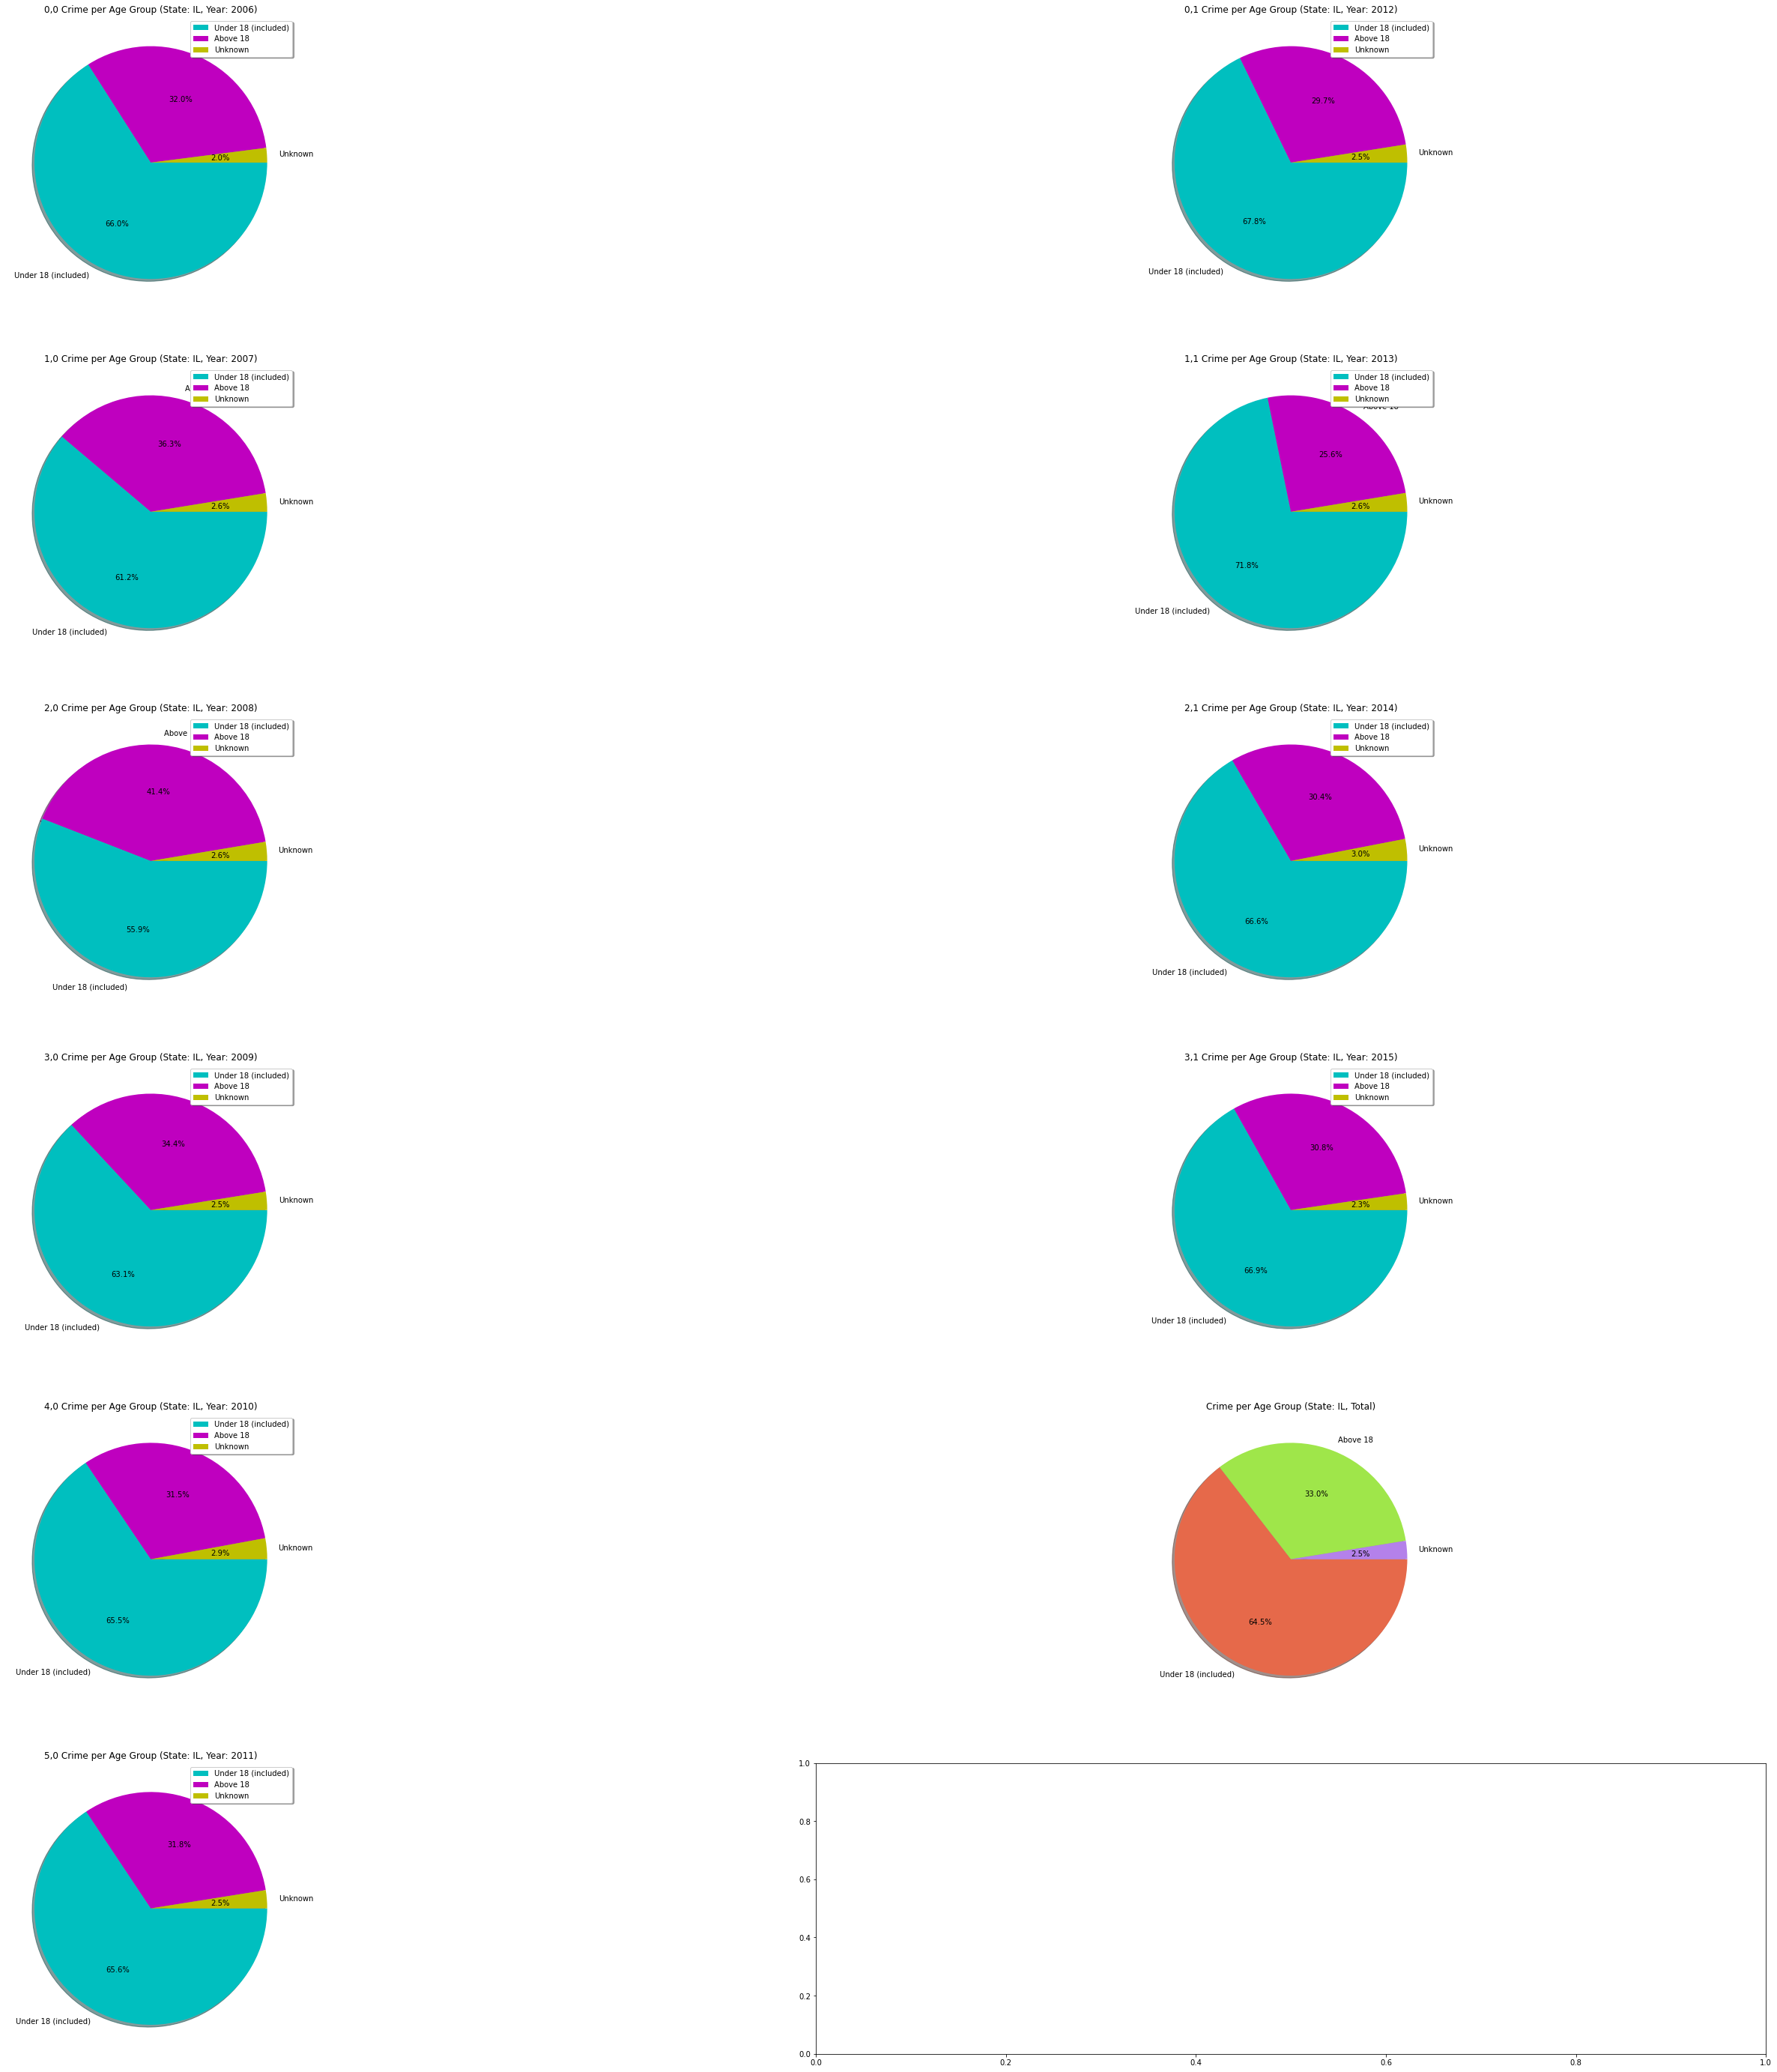

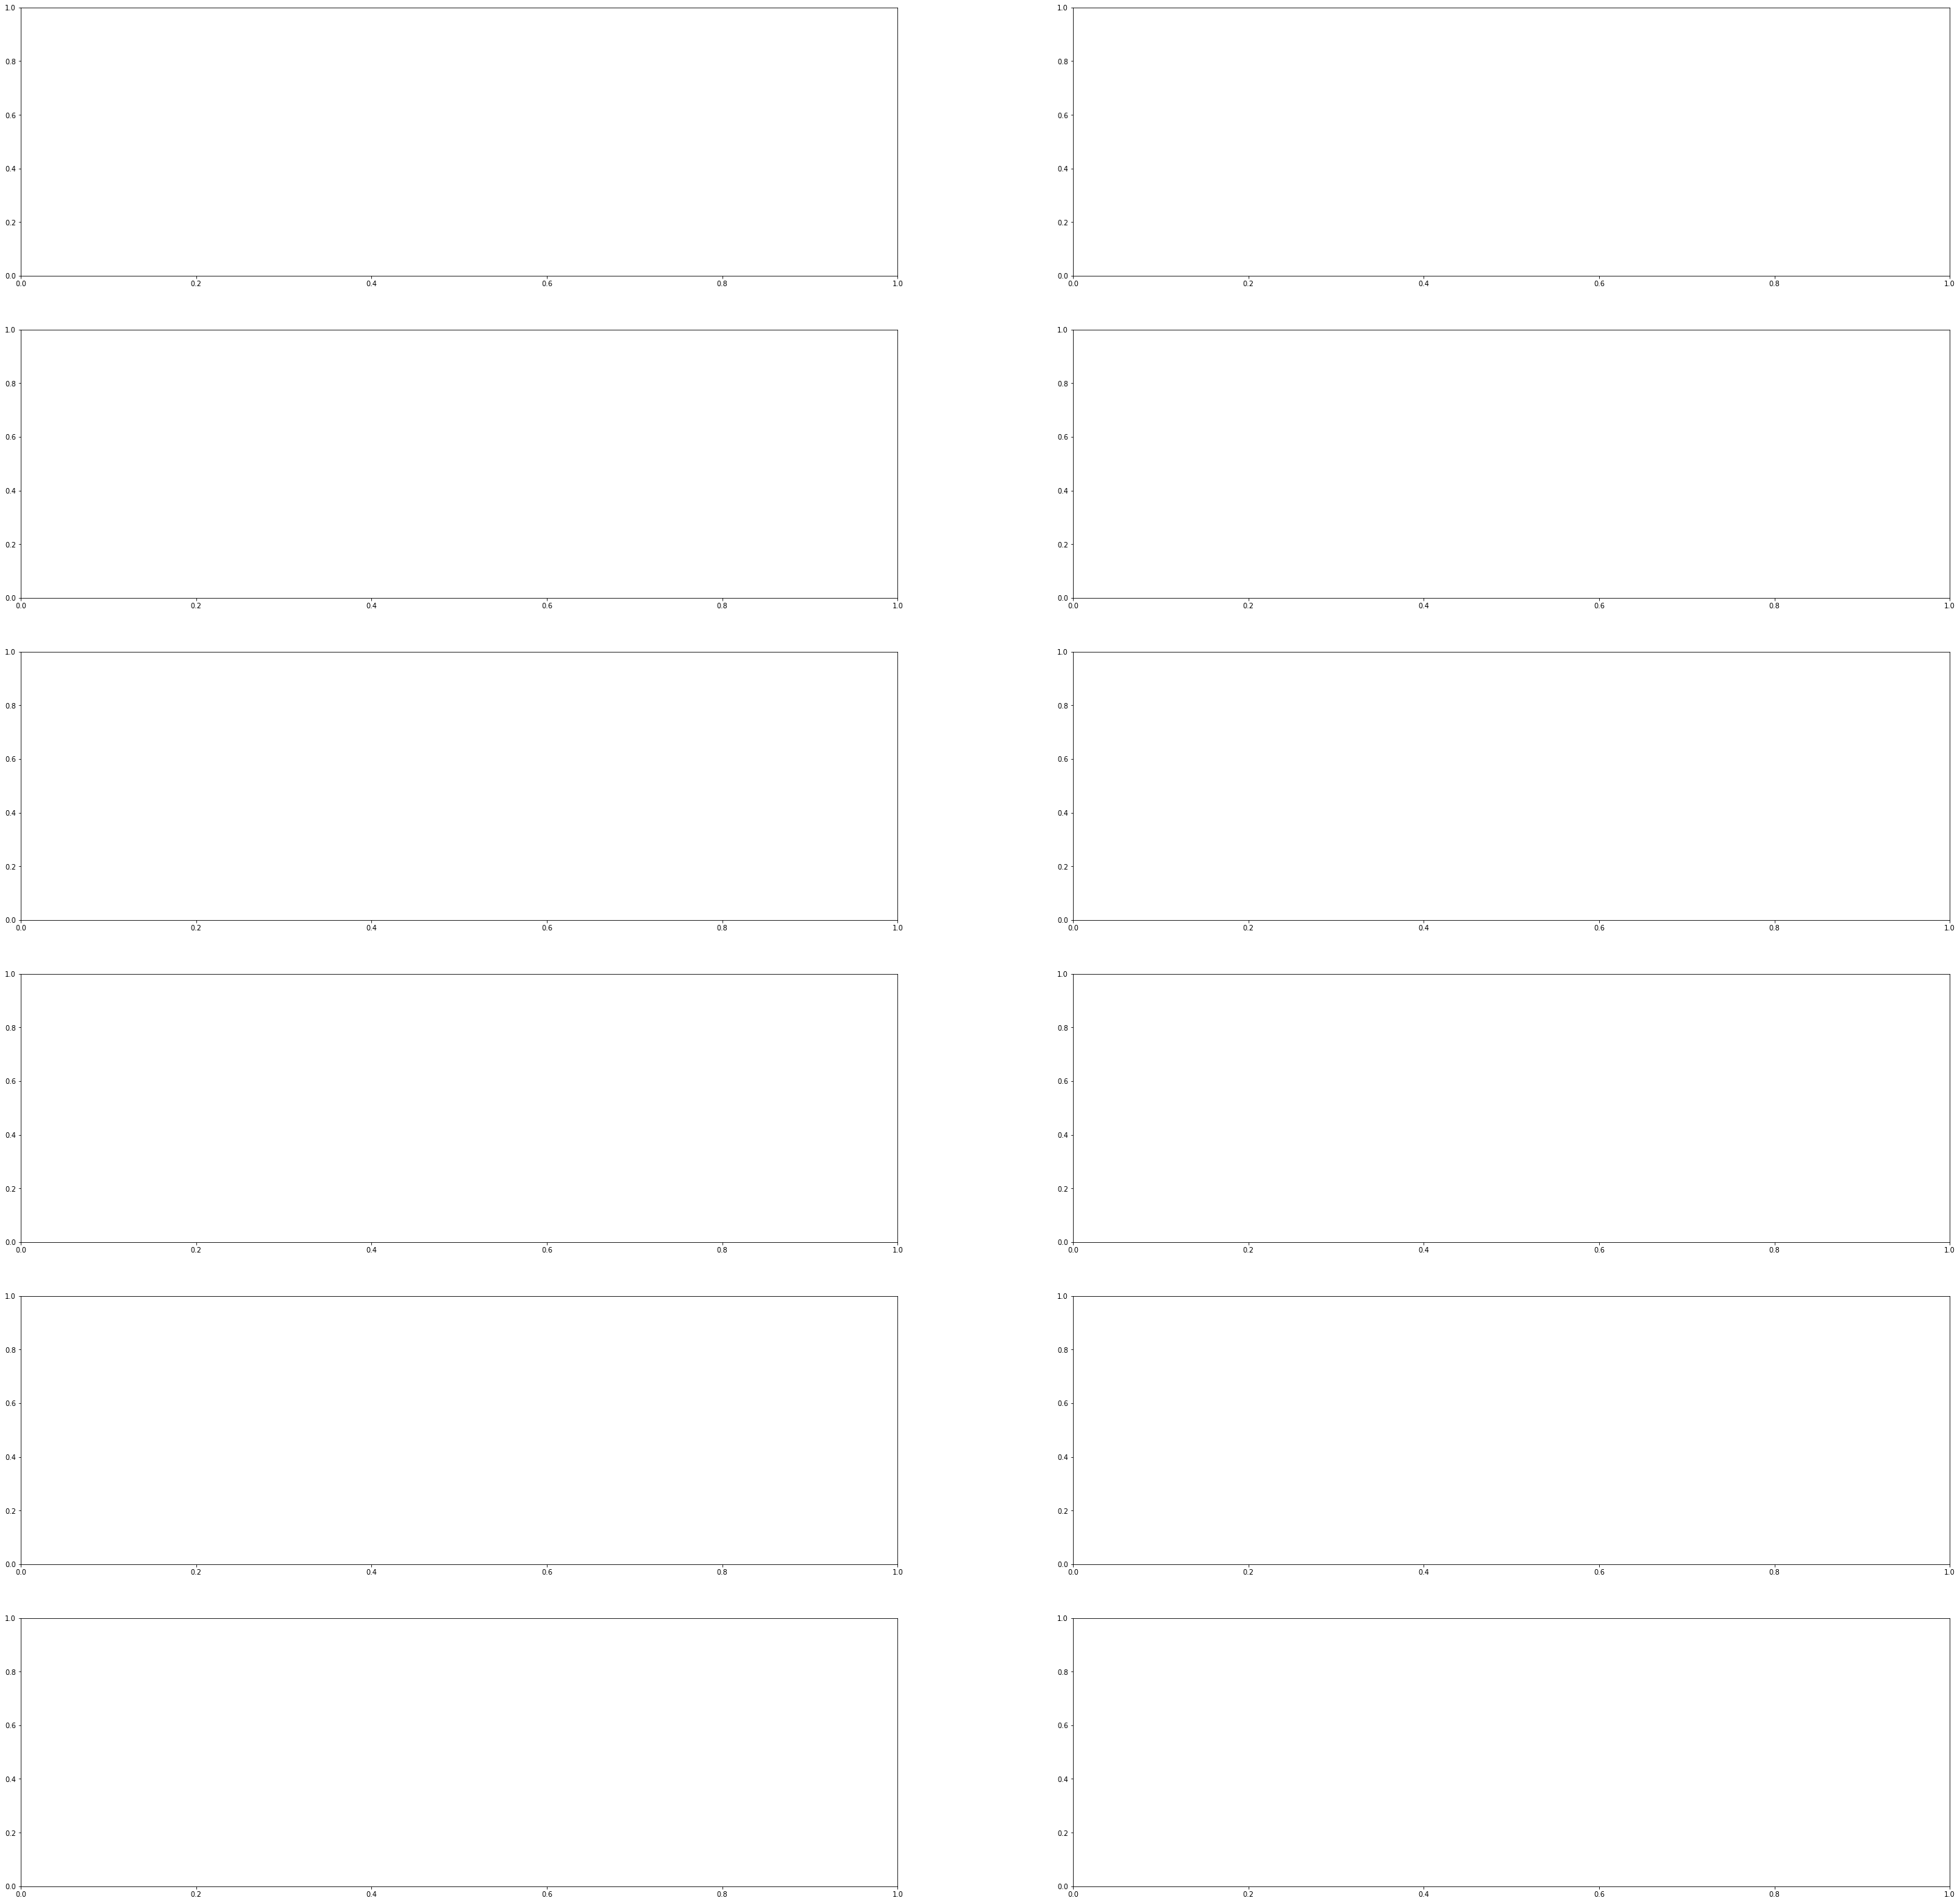

In [8]:
#call plot question 1 per state
gr_len=[(6,2),(6,2),(6,2),(6,2)]
x=0
for state in states:
    plot_age_qu1_per_state(state,gr_len[x][0],gr_len[x][1])
    #plot_loaction_q1_per_state(state,gr_len[x][0],gr_len[x][1])
    x+=1
    print("done plot for state " + state)
#state='TX'
#plot_qu1_per_state(state)    
print('\n\n\n\nDone all plots QU1 for states')

In [9]:
#function that handles the 2nd question, returning a series of pie plot figures.
def plot_ethnicity_q2_per_state_clean(state,x_len,y_len):
    take = ['incident_id','race_id','race_desc','location_id','location_region_type']
    colors = ['#6189c9',
              '#9648c7',
              '#969aab',
              '#bce386',
              '#e0b079',
              '#e34c1e',
              '#c51ee3',
              '#656fdb',
              '#879294',
              '#4ec200',
              '#61fff7']
    
    lock_labels = ['Property',
                  'Infrastructure', 
                  'Educational Grounds',
                  'Store',
                  'Other',
                  'Entertainment',
                  'Government',
                  'Religion',
                  'Travel',
                  'Nature',
                  'Rest']
    
    races_labels= ['Unknown',
                   'White',
                   'Black or African American',
                   'American Indian or Alaska Native',
                   'Asian',
                   'Asian, Native Hawaiian, or Other Pacific Islander',
                   'Chinese',
                   'Japanese',
                   'Native Hawaiian or Other Pacific Islander',
                   'Other',
                   'Multiple',
                   'Not Specified']
    columns_labels = [take[4]]
    columns_labels += races_labels.copy()#location type, race1, race2, race3, etc...
    total_bahor = None #holds all the data of the 10 years so that we can do a sum at the end   
    x, y=0,0
    name='race_desc'
    row_amount,col_amount = x_len,y_len
    fig, axis = plt.subplots(nrows = row_amount, ncols = col_amount, figsize=(150,150)) #per the size of how many graphs u want
    state_all_path = os.getcwd()+'\\'+state+'\\all'
    dirs = os.listdir(state_all_path)
    for file in dirs:
        d = state_all_path+'\\'+file
        df = load_csv(d)
        if df is None: # check if not NULL AKA exists(?)
            continue
        strip=state+'_'+'.csv'
        year=file.strip(strip) #get the year name
        new_df=df[take]
        data_list=[]
        for item in lock_labels: #every item here is a column in the bar plot  
            new_data=new_df.drop(new_df[new_df[take[4]]!=item].index)
            bahor = new_data[name].value_counts(sort=False)
            temp_list=[item]
            t_bahor = fix_value_count_clean(bahor, races_labels)
            temp_list+=t_bahor.tolist()
            data_list.append(temp_list) # list of lists that contain the data of the value counts
        plot_df=pd.DataFrame(data_list,columns=columns_labels)
        plot_df = plot_df.replace(0, np.nan)
        plot_df = plot_df.dropna(how='all', axis=0)
        plot_df = plot_df.dropna(how='all', axis=1)
        plot_df = plot_df.replace(np.nan, 0)
        title='crime location by race '+state+' '+year
        plot_df.plot(ax=axis[x,y],x=take[4], kind='bar', stacked=True,title=title)
        if x < row_amount-1:
            x+=1
        else:
            x=0
            y+=1
        print("done plot bar of " + state + " year " + year)
        
#function that helps recalibrate the given dataset per its labels.
def fix_value_count_clean(bahor,labels):
    b_list=bahor.keys().to_list()
    complete_labels=labels.copy()
    missing = []
    zeros = []
    fix_bahor = bahor.copy()
    for item in complete_labels:
        if item in b_list:
            continue
        else:
            missing.append(item)
            zeros.append(0)
    fix_bahor = fix_bahor.append(pd.Series(zeros, index = missing))
    return fix_bahor
   

In [18]:
#function caller for the 2nd question to generate the given figures we need.
for state in states:
    plot_ethnicity_q2_per_state_clean(state,6,2)

done plot bar of IL year 2006
done plot bar of IL year 2007
done plot bar of IL year 2008
done plot bar of IL year 2009
done plot bar of IL year 2010
done plot bar of IL year 2011
done plot bar of IL year 2012
done plot bar of IL year 2013
done plot bar of IL year 2014
done plot bar of IL year 2015
done plot bar of LA year 2005
done plot bar of LA year 2006
done plot bar of LA year 2007
done plot bar of LA year 2008
done plot bar of LA year 2009
done plot bar of LA year 2010
done plot bar of LA year 2011
done plot bar of LA year 2012
done plot bar of LA year 2013
done plot bar of LA year 2014
done plot bar of LA year 2015
done plot bar of TX year 2005
done plot bar of TX year 2006
done plot bar of TX year 2007
done plot bar of TX year 2008
done plot bar of TX year 2009
done plot bar of TX year 2010
done plot bar of TX year 2011
done plot bar of TX year 2012
done plot bar of TX year 2013
done plot bar of TX year 2014
done plot bar of TX year 2015
done plot bar of WA year 2007
done plot 

In [40]:
#function that splits the data per the train test split
def split_data(X,y,split, ratio):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=ratio)
    return X_train, X_test, y_train, y_test

#function that gets a state and a year, returns a FIXED dataframe & col for the sex code ML question.
def load_data_for_ML(state,year):
    file=state+'_'+str(year)+'.csv'
    path=state_all_path = os.getcwd()+'\\'+state+'\\all\\'+file
    df=load_csv(path)
    if df is None:
        return None, None
    save_cols = ['age_num','race_id','ethnicity_id']
    df=df.replace(['M','F'],[0,1])#adjsut to 1 and 0 binary
    df.drop(df[df.age_num < 0].index, inplace=True) # remove missing data that was prefilled with -1
    df.dropna(how='any', inplace = True) #remove all troubled data
    col = df['sex_code'] #split to col and df
    df_columns = list(df.columns)
    
    for item in df_columns:
        if item in save_cols:
            df_columns.remove(item)
    
    df.drop(df_columns,axis=1,inplace=True)#col so no effect
    
    for item in df:
        df[item] = df[item].values.astype(np.int64)
    col = pd.to_numeric(col, errors='coerce').convert_dtypes()
    df.fillna(0,inplace=True)
    col.fillna(0,inplace=True)
    return df,col

In [44]:
#predict the sex_code of the given state and year from the all csv file.
con_mat_array = []
con_mat_perc = []
for state in states:
    for year in range(2005,2016):
        Xr, yr = load_data_for_ML(state, year)
        if Xr is None:
            continue

        label_encoder = LabelEncoder()
        yr = label_encoder.fit_transform(yr)
        Xr = StandardScaler().fit_transform(Xr)

        Xr_train, Xr_test, yr_train, yr_test=split_data(Xr,yr,0.3,1)

        r_LG_Model = LogisticRegression().fit(X=Xr_train, y=yr_train)
        y_predict = r_LG_Model.predict(Xr_test)

        re = confusion_matrix(yr_test, y_predict)
        con_mat_array.append(re)

        score = f1_score(yr_test, y_predict, average='macro')
        con_mat_perc.append(score)

print(con_mat_perc) #print percents

File not dir exist: C:\Users\USER\Desktop\DataScience\IL\all\IL_2005.csv
[0.4322922947063788, 0.4310205183585313, 0.42550540016615895, 0.42165709598031176, 0.42314679463268573, 0.42875508892221986, 0.4207068148372766, 0.4272046589018303, 0.4167383820998279, 0.4320583794665324]
